(1797, 64)
3


<Figure size 640x480 with 0 Axes>

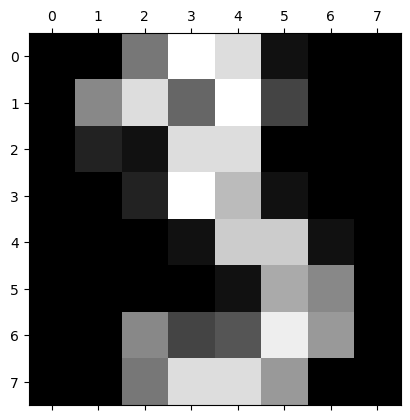

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.utils import shuffle

# Load dataset
digits = load_digits()

# Print dataset shape and target for the second sample
print(digits.data.shape)
print(digits.target[3])

# Visualize the image of the second sample
plt.gray()
plt.matshow(digits.images[3])
plt.show()

# Shuffle the data, keeping the corespondence between feature vector and it's label
np.random.seed(1)
data_, target_ = shuffle(digits.data, digits.target)


### Making a bare bones neural network to classify digits :
In this notebook, we will try to understand the building and training of a bare bones neural network, the math behind it, with our focus on classifying images that represent digits. Let's prepare the data first: In the above cell, we notice that we are given $1797$ images of size $8 \times 8$, as well as the corresponding ground truth value for each image. A data example is a tuple $(X^{(i)}, Y^{(i)})$ Where $X^{(i)}$ is called a feature vector, (or simply feature) and $Y^{(i)}$ the label for that feature vector (aka ground truth).

The main idea behind a neural network is that there exists some complex high-dimensional function $T$ from the feature space, to the label space, such that for any data example $(X^{(i)}, Y^{(i)})$,  $T(X^{(i)}) \sim Y^{(i)}$. That is, $T$ approximates the relationship between the feature vectors and their labels. Usually, our input feature might be a matrix, we want to reshape it into a column vector. So an $8 \times 8$ image is going to be flattend into a column vector, reading left to right, top to bottom, of dimension $64$, so our feature vectors live in $\mathbb R^{64}$. But in our case, SKlearn has already done half the job, flattening the image into a row vector of dimesion $64$, It is much more natural to have each feature as a column vector, and the training examples stacked columwise to form a matrix. 

Moreover, we know roughly that the neural network will "train" on the data, so we want to split our data into training, development (where will we evaluate it's performance and make necessary changes), and a final test set, which we will never see until we think our model is "finally" done, so as to not cheat and try to fit our model to the data that we're supposed to "predict" on. 

### Understanding normalization: 
For sake of visuals, suppose our input features are each just two dimensional points. The philosophy of normalization is that "relative" is more important than "absolute" meaning that how the features of our data set, is related to one another, is much more important then their actual values. Hence, on an intuitive leve, we even want to eliminate anything absolute from our input features. So imagine plotting the feautre vectors in its high dimensional space. We want the centroid of this plot to be at the origin. So we just compute the centroid vector (called "mean") and subtract it from each of our feature vectors. if $m$ is the number of examples, the mean is calculated as follows:
$$\mu = \frac{1}{m}\sum_{i = 1}^{m} X^{(i)} $$

Next, we want to know the "average" distance that each point is to  the mean, called the standard deviation: 
$$\sigma = \sqrt{ \frac{1}{m} \sum_{i=1}^{m}(X^{(i)}- \mu)^2 } $$

Finally, once we subtract out the centroid, so that our features are centered about the origin, we want the average deviation away from the origin to be one. So we just scale the vectors down by the standard deviation. (note that the standard deviation is a vector, that scales each "axis" independently, and hence the division here is just elementwise division, broadcasted over each vector)
$$ X^{(i)}_{norm} = \frac{{X^{(i)}-\mu}}{\sigma}$$

We see below that the random points (blue) and normalized points (pink) still share the same shape and inter-relationship. 
We will also first do an L2 normalization (turn vectors into unit vectors), just to ensure that our features don't have too large of a magnitude. 
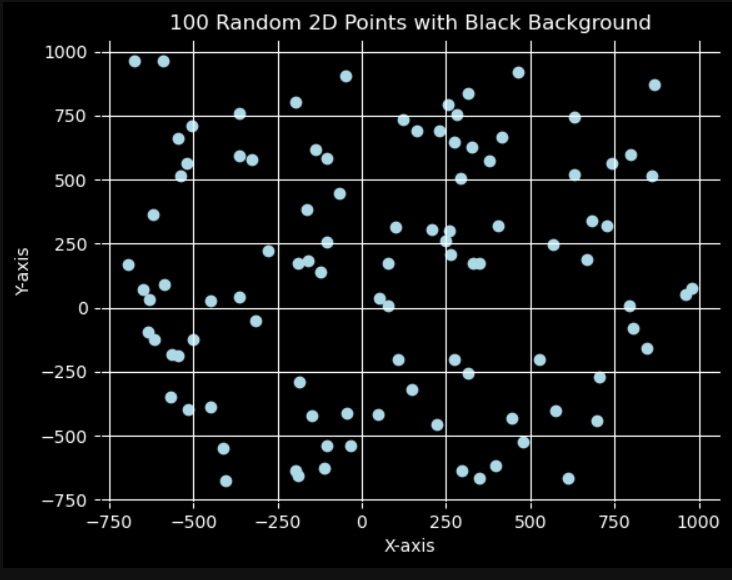
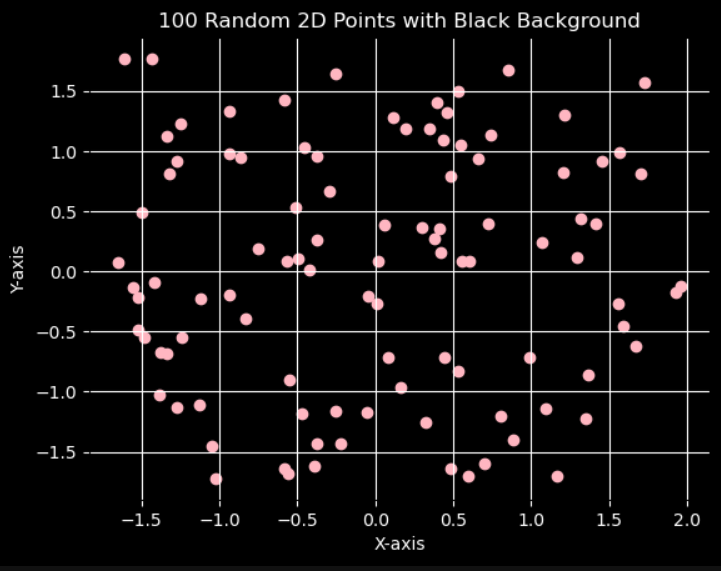



In [24]:
#normalization

X_prev = data_/np.linalg.norm(data_, axis = 1, keepdims = True)
m = X_prev.shape[0]
e = 0.00000001 #numerical stability
X_prev_mean = np.sum(X_prev, axis = 0, keepdims = True)/m
X_prev_deviation = np.sqrt(np.sum((X_prev - X_prev_mean)**2, axis = 0, keepdims = True)/m)
X_ = (X_prev - X_prev_mean)/(X_prev_deviation + e)
#check that normalization works
print(X_[1])
#we will take the first 1500 examples for training, the 200 examples for development, and the last 97 examples for test.
#we will also transpose the matrix, so that our features are column vectors instead of row vectors.
X_train = X_[:1500].T
print(X_train.shape)
X_dev = X_[1500:1700].T
print(X_dev.shape)
X_test = X_[1700:].T
print(X_test.shape)
#we see that now, the feature vectors are columns of our matrices, X_train, X_dev, X_test.


[ 0.          8.3369963   1.55676159  0.62348292  0.84159189  1.70138742
  1.91442295 -0.12563545 -0.05955753  2.115924    0.92413236  0.90805457
  0.50629541  0.40505773  0.82922685 -0.13061034 -0.04412544  0.89297863
  0.9797157   0.834688   -1.15705571 -1.26139189 -0.54774412 -0.11488858
 -0.0333373  -0.47891083  0.71963665  0.82522503 -1.61198076 -1.28551251
 -0.63110674 -0.04722047  0.         -0.67669173  0.01640613  1.04693235
 -1.41038664 -1.49274895 -0.826222    0.         -0.06161515 -0.53487254
  0.14031329  1.15830787 -1.22976866 -1.45846214 -0.79583077 -0.08996861
 -0.03590278  1.27829872  1.0757585   0.22534197 -1.80482941 -1.45713418
 -0.75553924 -0.21234332 -0.02359584  9.1623548   1.94719509 -1.42523668
 -2.37326603 -1.14176155 -0.50519614 -0.19619223]
(64, 1500)
(64, 200)
(64, 97)


### One hot encoding of the ground truth: 

For reasons that will become clear a little later, we want our ground truth to be a column vector (of dimension 10 in this case), with zeros everywhere but a one at the position of the label. So if $Y^{(i)} = 2$, we want a column vector $ Y^{(i)}_{enc} =[0,0,1,0,0,0,0,0,0,0]^{T}$. Let's do that, also split our ground truth vectors into test, dev, and train sets, so that each feature vector algins with it co-respoding ground truth vector. 

In [25]:
Y_ = target_
print(Y_.shape)
num_classes = int(10) 
# we will initialize so that first we have 10 rows, then transpose, as usual. 
Y = np.zeros((Y_.shape[0], num_classes))
print(Y.shape)
#we will perform one hot encoding now. 
row_indices = np.arange(Y_.shape[0])
Y[row_indices, Y_] = 1
#it is clear that our one hot encoding works
print(f"{Y_[5]} -> {Y[5]}")
#now, we do the same train, test, dev, split on Y, and also transpose to ensure our ground truth vectors are columns
Y_train = Y[:1500].T
print(Y_train.shape)
Y_dev = Y[1500:1700].T
print(Y_dev.shape)
Y_test = Y[1700:].T
print(Y_test.shape)

(1797,)
(1797, 10)
0 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(10, 1500)
(10, 200)
(10, 97)


### Finishing the setup
Right now, we've done a bunch of things, and said a lot of "it will be clear later" (call it a bad thriller). But anyway, let's finish up the processing of data, by making a class, and also making 5 batches of 300 examples for training.

In [26]:
class Data: 
    def __init__ (self, X_train, X_dev, X_test, Y_train, Y_dev, Y_test): 
        self.XT_batches = []
        self.YT_batches = []
        batch_size = 300
        for i in range(1, 6): 
            start_idx = (i - 1) * batch_size
            end_idx = i * batch_size
            self.XT_batches.append(X_train[:, start_idx:end_idx])
            self.YT_batches.append(Y_train[:, start_idx:end_idx])
            
        self.X_dev = X_dev
        self.Y_dev = Y_dev
        self.X_test = X_test
        self.Y_test = Y_test

data = Data(X_train, X_dev, X_test, Y_train, Y_dev, Y_test)

In [27]:
#just to check batch shapes
for i in range (0,5): 
    print(f"X_train_batches has shape: {data.XT_batches[i].shape}, Y_train_batches has shape:{data.YT_batches[i].shape}")

X_train_batches has shape: (64, 300), Y_train_batches has shape:(10, 300)
X_train_batches has shape: (64, 300), Y_train_batches has shape:(10, 300)
X_train_batches has shape: (64, 300), Y_train_batches has shape:(10, 300)
X_train_batches has shape: (64, 300), Y_train_batches has shape:(10, 300)
X_train_batches has shape: (64, 300), Y_train_batches has shape:(10, 300)


### The zoomed out picture: 
so we want a function $T$ such that for a given data example $(X^{(i)}, Y^{(i)})$ $T(X^{(i)})$ approximates $Y^{(i)}$. But it's very hard to give an exact explicit  qualitative description of $T$, even more so if our data is high-dimensional. As an example, let us look at the breast cancer data set [Breast Cancer Wisconsin](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic), which gives us in total of thirty numerical features, but let us just examine the first few. 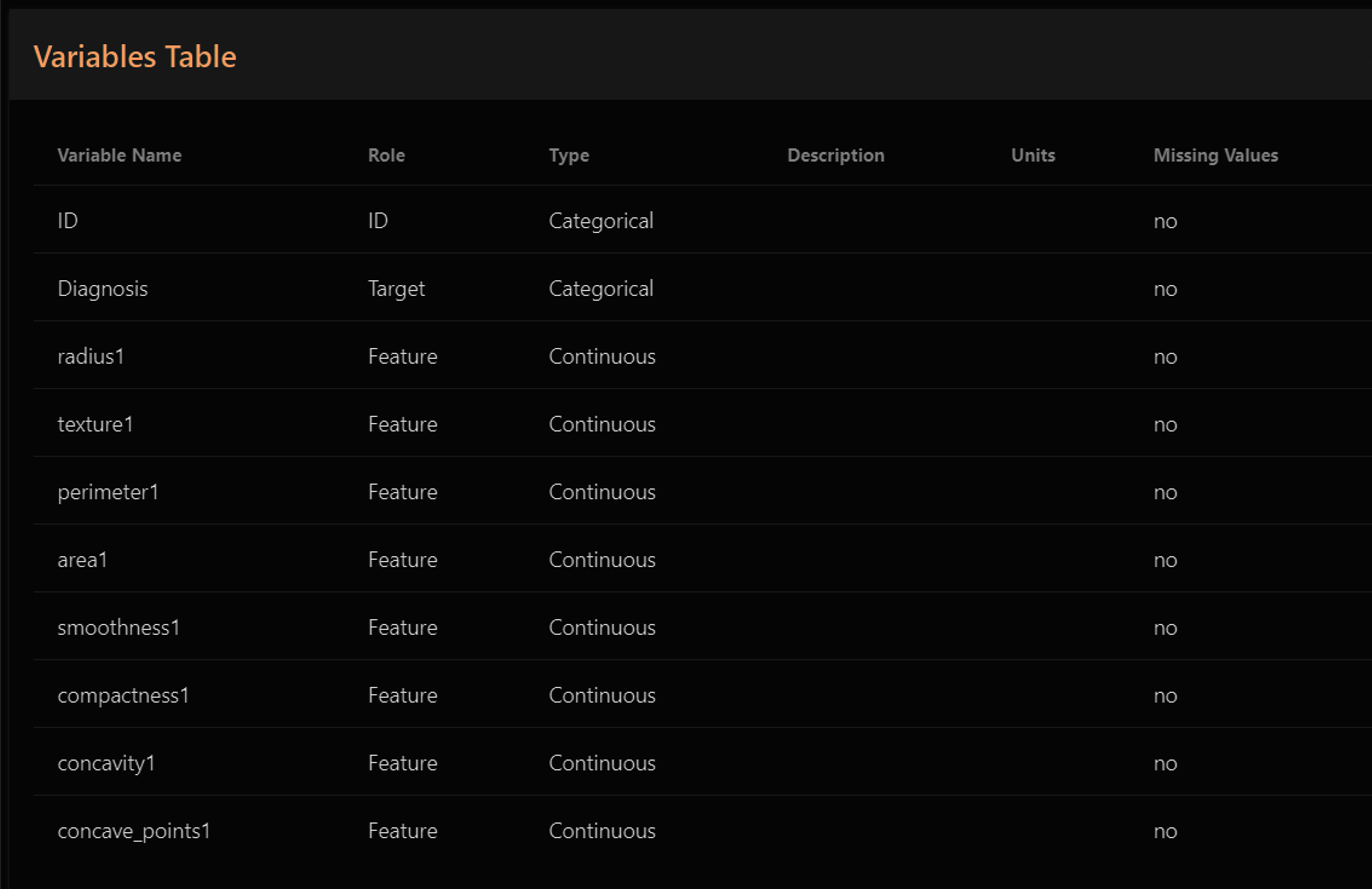
The idea is that, it's hard to look at such high dimensional data and go "$T$ is a function that will weigh radius1 with highest priority, followed by radius2, followed by perimeter1, followed by texture1.." and so forth. 

Our approach instead will be to make a complex function $T$ whose output is tunable by lots and lots of knobs. Think of $T$ as a radio with thousands of knobs. We don't really know what each knob does, but we can hear the output of the radio. Now, when tuning this radio, we won't just arbitarity turn the knobs, even if we don't know what each knob does, we know that we're tuning in the wrong direction, if we hear more noise, and we're tuning in the right direction if we hear less noise (we indeed can hear the music). 

In the case of a radio, our ears measure the error between music and noise. In the case of our function $T$, a loss function $L$ will measure the error between $T(X^{(i)})$ and $Y^{(i)}$. In practise, we pass an entire batch of input examples $X$ into $T$ and take it's average loss (also called cost) with the co-respoding batch of output examples $Y$. For the radio, let's say we bump up or bump down a knob by a very small amount, yet again our ears will tell us if we're moving towards more noise, or less noice. For our function $T$ the "partial derivative" of the cost with respect to a knob, will tell us if we're moving towards more error or less error. 

### Stepping down into a lower level
Now, there must be a voice in the reader's head, asking me to quit stalling, and get to the point. 
#### Overview of a neural network
Notation: square bracker superscript denotes layer number, and paranthesis, denotes example number. :) 
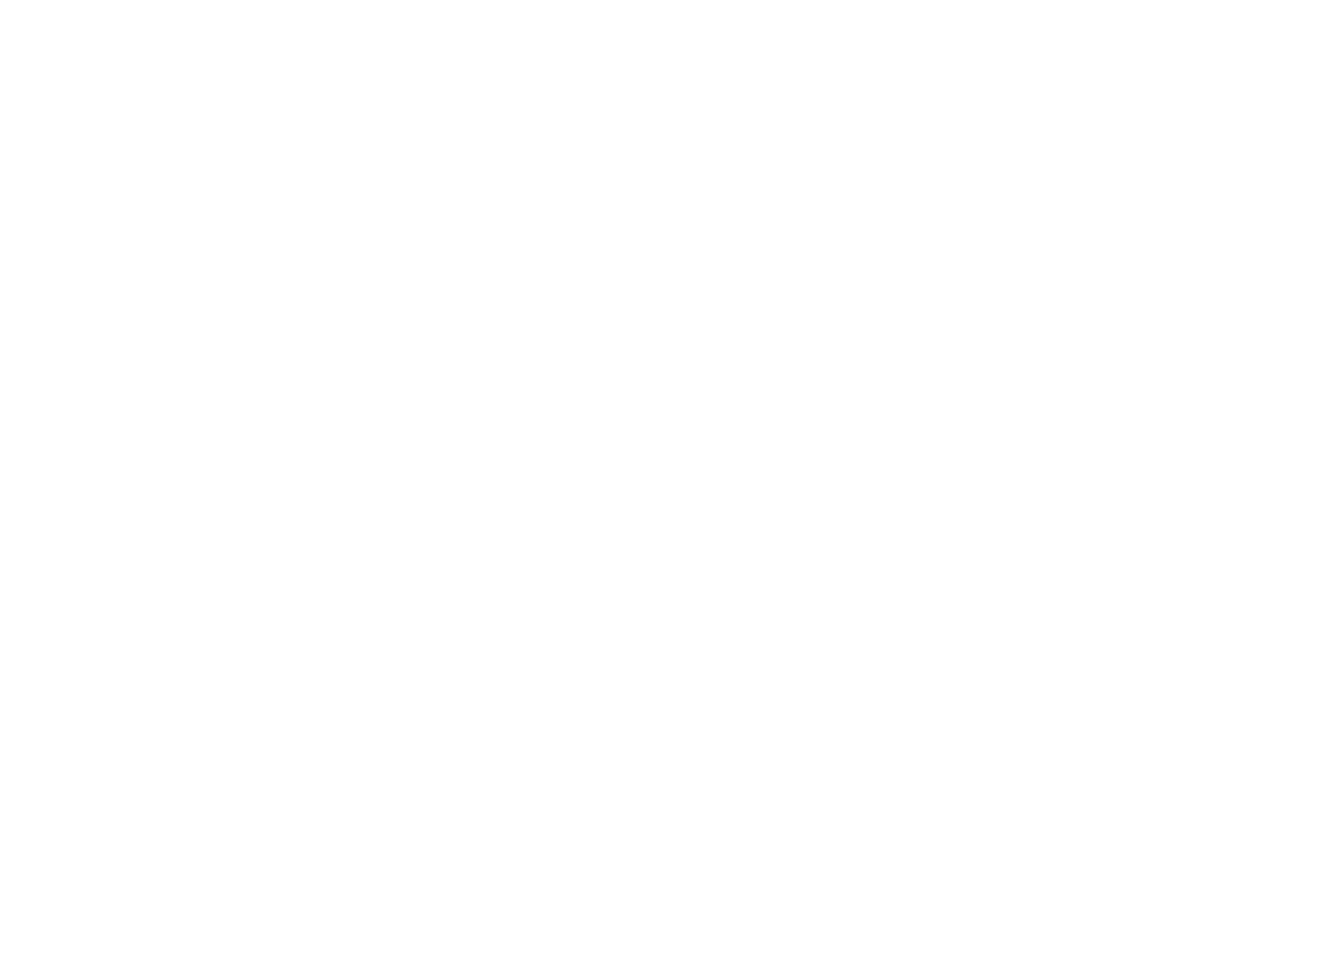
We see in the above diagram, that each layer's Activations are passed through the $f_1$ kind of functions, which also take the knobs as input, then trough the $f_2$ kind of functions, which become the Activations of the next layer. The output layer should be a matrix of the same dimensions as the ground truth. The loss of the output vectors of each traning example is then evaluted with the co-responding ground truth vector, and then is averaged out to get the cost. This step is called "forward propogation". 

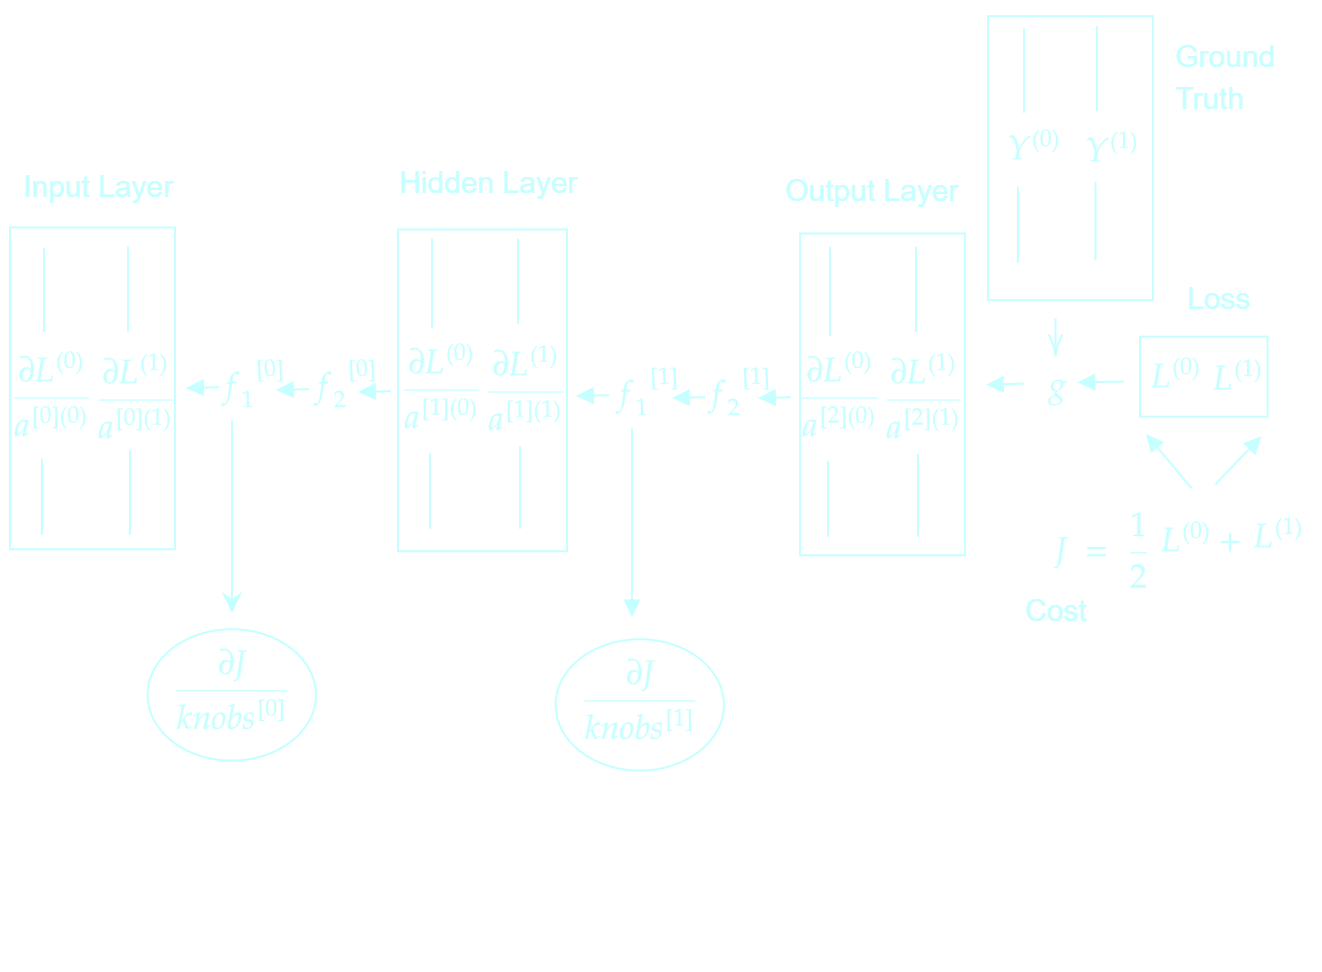
Now, notice that $g$ is the loss function, computing the loss of $a^{[2](0)}$ against $Y^{(0)}$ and $a^{[2](1)}$ against $Y^{(1)}$. Now, ignoring the rest of the model behing the last layer, $g$ is going to send a message to both $a^{[2](0)}$ $a^{[2](1)}$ telling how they should change so that $L^{(0)}$ and $L^{(1)}$ should respectively decrease. We can imagine this message passing (from right to left) to $knobs^{[1]}$ through $f_2^{[1]}$ and then $f_1^{[1]}$ and finally reaching $knobs^{[1]}$. (which is something we can actually tune to change the output layer). Similarly, we can imagine the message reaching $knobs^{[0]}$ as well. Where we will tune these knobs to to affect the output in such a way that the cost $J$ finally decreases a little. 

This process, is known as a training epoch, or a training cycle. 


#### What is this message? 
The hint is already sprinked into the notation, the message that each layer recives is a matrix, (the same shape as that of the layer's activation matrix itself) which for each column vector, we compute a vector containing the derivatives of that activation column's components, with respect to it's co-responding loss. This will tell us how the loss of that training example, is affected by slightly pertubating the components of the activation column.

Now, the message that the knobs recive is also a matrix, and each entry of this message is the derivative of the cost, with respect to the co-responding knob. This will tell us how the cost of the entire training batch, is affecting by slightly pertubating the components of the knob matrix. 

Now, it is still exactly not clear what we will do with these derivates, and how exactly do we update these knobs